In [16]:
from io import StringIO
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_file = "/disco-grande/datos.csv"
df = pd.read_csv(data_file)

In [4]:
df = df[df["cc_chestpain"] !=-2147483648]

In [5]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols = [col for col in categorical_cols if col != 'disposition']

In [6]:
float_feature_mask = df.dtypes==np.float64
int64_feature_mask = df.dtypes==np.int64
int32_feature_mask = df.dtypes==np.int32
uint8_feature_mask = df.dtypes==np.uint8
numeric_cols = df.columns[uint8_feature_mask].tolist() + df.columns[float_feature_mask].tolist() + df.columns[int64_feature_mask].tolist() + df.columns[int32_feature_mask].tolist()

In [7]:
df["disposition"] =  df["disposition"].apply(lambda x: 1 if x  == 'Admit' else 0)
# ONE HOT ENCODING de categoricos
df = pd.get_dummies(df, columns=categorical_cols)

In [8]:
null_columns= []
for col in df.columns:
    num_nulos = df[col].isna().sum()
    if num_nulos:
        null_columns.append((col, num_nulos))

In [9]:
for col, l in null_columns:
    df[col] = df[col].fillna(0)

In [10]:
total_count = len(df)
NULL_THREESHOLD = 0.4
exclude_columns = [col for col, count in null_columns if  count / total_count > NULL_THREESHOLD  ]
feat_labels = [col  for col in df.columns if col != 'disposition' and col not in exclude_columns]

In [11]:
X = df[feat_labels]
Y = df['disposition']
random_state=42
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=random_state)
del X
del Y

In [28]:
n_splits = 4
def execute_model_base(model, cv = None, X_train = X_train, X_test = X_test, print_score=True, plot = True):
  if cv:
    for (train_idx, test_idx) in cv.split(X_train,Y_train):
      if type(X_train) == np.ndarray:
        model.fit(X_train[train_idx], Y_train[train_idx] if type(Y_train) == np.ndarray else Y_train.iloc[train_idx])
      else:
        model.fit(X_train.iloc[train_idx], Y_train.iloc[train_idx])
  else:
    model.fit(X_train, Y_train)

  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f} ".format(score))
    print("Precision = {0:.5f} ".format(precision))
    print("Recall = {0:.5f} ".format(recall))  
    print("AUC = {0:.5f}".format(auc))
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
def plot_score(model, print_score=True, plot = True):
  Y_pred = model.predict(X_test)
  score = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)
  recall = recall_score(Y_test, Y_pred)
  auc = roc_auc_score(Y_test, Y_pred)
  if print_score:
    print("Score = {0:.5f} ".format(score))
    print("Precision = {0:.5f} ".format(precision))
    print("Recall = {0:.5f} ".format(recall))  
    print("AUC = {0:.5f}".format(auc))
  conf_matrix = confusion_matrix(Y_pred, Y_test)
  if plot:
    sns.heatmap(conf_matrix,annot=True,fmt="d")
    plt.show()
def execute_model_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=KFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_stratified_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=StratifiedKFold(n_splits=n_splits, random_state = random_state), *args, **kwargs)
def execute_model_repeated_kfold(model, *args, **kwargs):
  return execute_model_base(model, cv=RepeatedKFold(n_repeats=8, n_splits=n_splits, random_state = random_state), *args, **kwargs)
def print_feature_importance_lgbm(model):
  feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])
  return feature_imp.sort_values("Value", ascending =False)
def print_feature_importance_rf(model):
  sfm = SelectFromModel(model)
  sfm.fit(X_train, Y_train)
  for feature_list_index in sfm.get_support(indices=True):
      print(feat_labels[feature_list_index])

Score = 0.86384 
Precision = 0.84742 
Recall = 0.65817 
AUC = 0.80420


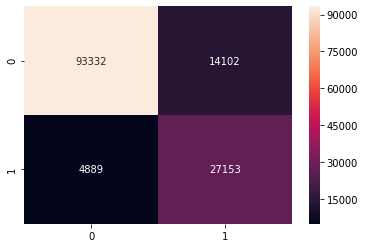

In [30]:
model_rf = RandomForestClassifier(n_estimators=50)
execute_model_stratified_kfold(model_rf)

In [ ]:
joblib.dump(model_rf, 'models/normal_rf.model')

Score = 0.84926 
Precision = 0.70750 
Recall = 0.83600 
AUC = 0.84541


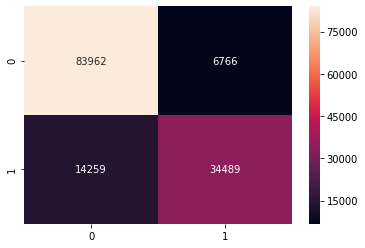

CPU times: user 11min 18s, sys: 11.1 s, total: 11min 29s
Wall time: 57.3 s


In [14]:
%%time
model = LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', max_depth=20, num_leaves=50)
execute_model_stratified_kfold(model)

In [15]:
df_features = print_feature_importance_lgbm(model)
df_features

,Value,Feature
691,218,esi
690,202,age
689,140,n_edvisits
688,136,triage_vital_hr
687,133,n_admissions
686,97,triage_vital_temp
685,96,dep_name_A
684,90,meds_cardiovascular
683,83,insurance_status_Self pay
682,79,meds_psychotherapeuticdrugs


In [ ]:
%%time
model = LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt', max_depth=20, num_leaves=50)
execute_model_stratified_kfold(model)

In [32]:
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 3, # Updated from nthread
          'num_leaves': 64,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 5,
          'reg_lambda': 10,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

# Create parameters to search
gridParams = {
    #0.15,
    'learning_rate': [0.15, 0.1],
    'n_estimators': [40, 80],
    'num_leaves': [6,8,12,16, 20, 25,30],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [42], # Updated from 'seed'
#     'colsample_bytree' : [0.65, 0.66],
#     'subsample' : [0.7,0.75],
#     'reg_alpha' : [1,1.2],
#     'reg_lambda' : [1,1.2,1.4],
    }


In [33]:
mdl = LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 3, # Updated from 'nthread'
          silent = True,
          is_unbalance=True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])


In [ ]:
%%time
grid = GridSearchCV(mdl, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=2)
grid.fit(X_train, Y_train)

{'boosting_type': 'gbdt', 'learning_rate': 0.1, 'n_estimators': 40, 'num_leaves': 16, 'objective': 'binary', 'random_state': 42}
0.8571452470574177
Score = 0.85896 
Precision = 0.82462 
Recall = 0.66448 
AUC = 0.80256


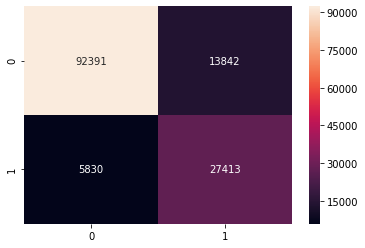

In [29]:
print(grid.best_params_)
print(grid.best_score_)
plot_score(grid.best_estimator_)

Score = 0.87370 
Precision = 0.83677 
Recall = 0.71187 
AUC = 0.82677


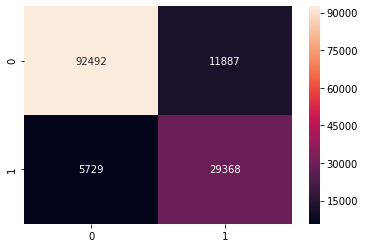

In [13]:
model = XGBClassifier(max_depth=20, nrounds=30, colsample_bylevel=0.05, nthread=-1, eta=0.3 )
execute_model_stratified_kfold(model)

In [20]:
df_features[df_features["Feature"] == 'anemia']

,Value,Feature
467,4,anemia
